In [275]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [276]:
TRAY_HSV_LOWER_BOUND = (85, 40, 20)
TRAY_HSV_UPPER_BOUND = (130, 255, 255)

TRAY_BOX_PIX = (
    250,
    20,
    630,
    300,
)  # (x1, y1, x2, y2) coordinates of the tray box in the image

CHEESE_W = 97


In [277]:
first_img_path = "/home/parth/snaak/data/SCH_images_041125/cheese_check_4/image_20250411-150657.png"
second_img_path = "/home/parth/snaak/data/SCH_images_041125/cheese_check_4/image_20250411-150700.png"

first_img = cv2.imread(first_img_path)
second_img = cv2.imread(second_img_path)

# resize the images to 840x480
first_img = cv2.resize(first_img, (840, 480))
second_img = cv2.resize(second_img, (840, 480))

In [278]:
# Crop the tray box from the bread image
first_crop = first_img[TRAY_BOX_PIX[1]:TRAY_BOX_PIX[3], TRAY_BOX_PIX[0]:TRAY_BOX_PIX[2]]

# Crop the tray box from the first ham image
second_crop = second_img[TRAY_BOX_PIX[1]:TRAY_BOX_PIX[3], TRAY_BOX_PIX[0]:TRAY_BOX_PIX[2]]

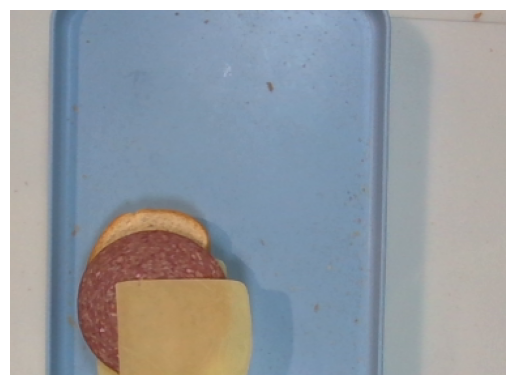

In [279]:
plt.imshow(cv2.cvtColor(first_crop, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

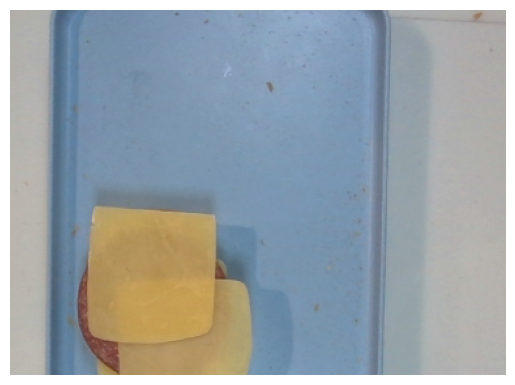

In [280]:
plt.imshow(cv2.cvtColor(second_crop, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

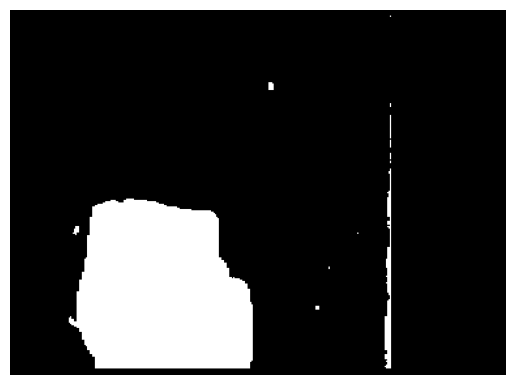

In [ ]:
# Segment tray from the second image using tray HSV values
# Convert the image to HSV color space
second_hsv = cv2.cvtColor(second_crop, cv2.COLOR_BGR2HSV)
tray_hsv_lower_bound = np.array(TRAY_HSV_LOWER_BOUND, dtype=np.uint8)
tray_hsv_upper_bound = np.array(TRAY_HSV_UPPER_BOUND, dtype=np.uint8)
tray_mask = cv2.inRange(second_hsv, tray_hsv_lower_bound, tray_hsv_upper_bound)

# Invert the tray mask
tray_mask_inv = cv2.bitwise_not(tray_mask)

# Find the bounding box of the tray
contours, _ = cv2.findContours(tray_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    tray_x, tray_y, tray_w, tray_h = cv2.boundingRect(largest_contour)


# Black out everything outside the tray box coordinate in tray_mask_inv
tray_mask_inv[0:tray_y+5, :] = 0
tray_mask_inv[tray_y+tray_h-5:, :] = 0
tray_mask_inv[:, 0:tray_x+5] = 0
tray_mask_inv[:, tray_x+tray_w-5:] = 0

plt.imshow(tray_mask_inv, cmap='gray')
plt.axis('off')
plt.show()

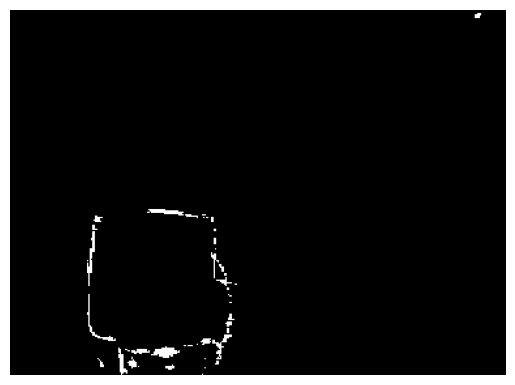

In [ ]:
BREAD_HSV_LOWER_BOUND_STRICT = (10, 60, 100)
BREAD_HSV_UPPER_BOUND_STRICT = (20, 110, 220)

second_hsv = cv2.cvtColor(second_crop, cv2.COLOR_BGR2HSV)
bread_hsv_lower_bound = np.array(BREAD_HSV_LOWER_BOUND_STRICT, dtype=np.uint8)
bread_hsv_upper_bound = np.array(BREAD_HSV_UPPER_BOUND_STRICT, dtype=np.uint8)
bread_mask = cv2.inRange(second_hsv, bread_hsv_lower_bound, bread_hsv_upper_bound)
bread_mask_inv = cv2.bitwise_not(bread_mask)

plt.imshow(bread_mask, cmap='gray')
plt.axis('off')
plt.show()

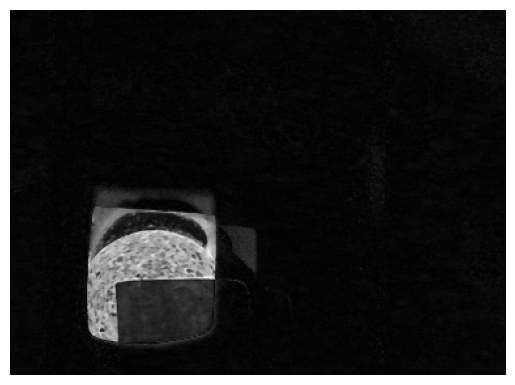

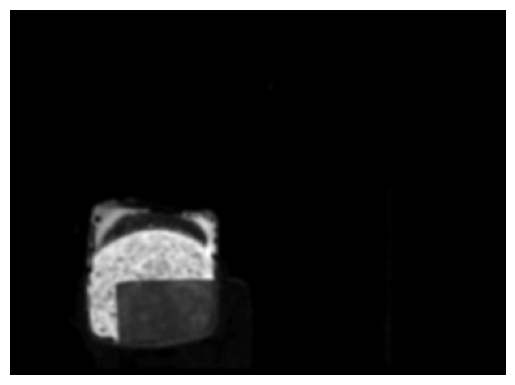

In [287]:
# Calculate the difference between the two images
diff = cv2.absdiff(first_crop, second_crop)
gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_diff, cmap='gray')
plt.axis('off')
plt.show()


# And operate the difference image with bread mask and tray mask
gray_diff = cv2.bitwise_and(gray_diff, gray_diff, mask=tray_mask_inv)
gray_diff = cv2.bitwise_and(gray_diff, gray_diff, mask=bread_mask_inv)


# Remove noise from the difference image
gray_diff = cv2.GaussianBlur(gray_diff, (7, 7), 0)

plt.imshow(gray_diff, cmap='gray')
plt.axis('off')
plt.show()

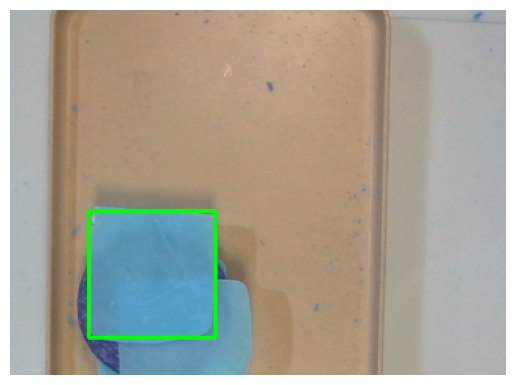

In [288]:
cheese_box = [0, 0, CHEESE_W, CHEESE_W] # (x1, y1, x2, y2) coordinates of the cheese box in the image

max_sum = 0
best_cheese_box = None

# Slide the cheese box over the image
for col in range(0, gray_diff.shape[1] - CHEESE_W): # iterate along image width
    cheese_box[0] = col
    cheese_box[2] = col + CHEESE_W

    for row in range(0, gray_diff.shape[0] - CHEESE_W): # iterate along image height
        cheese_box[1] = row
        cheese_box[3] = row + CHEESE_W

        cheese_crop = gray_diff[cheese_box[1]:cheese_box[3], cheese_box[0]:cheese_box[2]]
        cheese_crop_sum = np.sum(cheese_crop)
        if cheese_crop_sum > max_sum:
            max_sum = cheese_crop_sum
            best_cheese_box = cheese_box.copy()

# Draw the best cheese box on the image
plot_img = second_crop.copy()
plot_img = cv2.rectangle(plot_img, (best_cheese_box[0], best_cheese_box[1]), (best_cheese_box[2], best_cheese_box[3]), (0, 255, 0), 2)
plt.imshow(plot_img)
plt.axis('off')
plt.show()

    

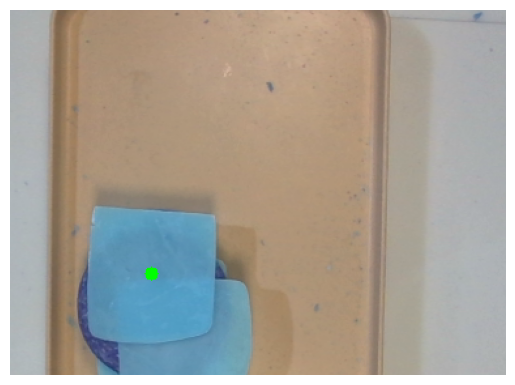

In [289]:
# Plot the center of the cheese box on second image copy
plot_img = second_crop.copy()
cheese_box_center = (best_cheese_box[0] + CHEESE_W // 2, best_cheese_box[1] + CHEESE_W // 2)
plot_img = cv2.circle(plot_img, cheese_box_center, 5, (0, 255, 0), -1)
plt.imshow(plot_img)
plt.axis('off')
plt.show()